In [ ]:
!wget http://di.ubi.pt/~hugomcp/cv/GTSRB_Classification.zip

--2023-04-05 11:24:02--  http://di.ubi.pt/~hugomcp/cv/GTSRB_Classification.zip
Resolving di.ubi.pt (di.ubi.pt)... 193.136.66.5
Connecting to di.ubi.pt (di.ubi.pt)|193.136.66.5|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ubi.pt/~hugomcp/cv/GTSRB_Classification.zip [following]
--2023-04-05 11:24:03--  https://www.di.ubi.pt/~hugomcp/cv/GTSRB_Classification.zip
Resolving www.di.ubi.pt (www.di.ubi.pt)... 193.136.66.5
Connecting to www.di.ubi.pt (www.di.ubi.pt)|193.136.66.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65502484 (62M) [application/zip]
Saving to: ‘GTSRB_Classification.zip.1’

GTSRB_Classificatio 100%[===================>]  62.47M  23.9MB/s    in 2.6s    

2023-04-05 11:24:06 (23.9 MB/s) - ‘GTSRB_Classification.zip.1’ saved [65502484/65502484]



In [ ]:
!rm test -rf
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile

# specify the file name and path
zip_path = 'drive/MyDrive/datasets/test.zip'

# open the zip file for reading
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  # extract all files to a directory with the same name as the zip file
  zip_ref.extractall('.')

In [ ]:
!rm GTSRB -rf
!unzip GTSRB_Classification.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: GTSRB/3_25.jpg          
  inflating: GTSRB/31_289.jpg        
  inflating: GTSRB/7_566.jpg         
  inflating: GTSRB/13_888.jpg        
  inflating: GTSRB/40_202.jpg        
  inflating: GTSRB/38_895.jpg        
  inflating: GTSRB/25_108.jpg        
  inflating: GTSRB/23_88.jpg         
  inflating: GTSRB/16_27.jpg         
  inflating: GTSRB/19_141.jpg        
  inflating: GTSRB/38_467.jpg        
  inflating: GTSRB/9_874.jpg         
  inflating: GTSRB/24_118.jpg        
  inflating: GTSRB/8_469.jpg         
  inflating: GTSRB/33_366.jpg        
  inflating: GTSRB/11_595.jpg        
  inflating: GTSRB/13_651.jpg        
  inflating: GTSRB/13_889.jpg        
  inflating: GTSRB/10_1140.jpg       
  inflating: GTSRB/25_874.jpg        
  inflating: GTSRB/2_393.jpg         
  inflating: GTSRB/9_450.jpg         
  inflating: GTSRB/30_138.jpg        
  inflating: GTSRB/12_250.jpg        
  inflating: GTSRB/7_2.jpg   

In [ ]:
import glob
from random import shuffle, choice
from tqdm import trange, tqdm
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle', 'choice']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
img_files = glob.glob('GTSRB/*')
print(len(img_files))

26639


In [ ]:
imgs_by_class = {}
# group files by class
for f in img_files:
  cls_name = f.split('/')[-1].split('_')[0]
  if cls_name not in imgs_by_class.keys():
    imgs_by_class[cls_name] = [f]
  else:
    imgs_by_class[cls_name].append(f)

# group files by class and in series of 30
# the result will be a list of lists each one with lenght of 30
for cls in imgs_by_class.keys():
  imgs_by_class[cls] = sorted(imgs_by_class[cls], key=lambda x: int(x.split('_')[-1].split('.')[0]))
  imgs_by_class[cls] = [imgs_by_class[cls][i*30:i*30+30] for i in range(len(imgs_by_class[cls])//30 + 1)]

In [ ]:
val_test_files = glob.glob('Test/*.png')
val_test_csv = glob.glob('Test/*.csv')[0]
print(len(val_test_files))
val_test_csv

12630


'Test/Test.csv'

In [ ]:
import pandas as pd

val_test = {}
df = pd.read_csv(val_test_csv)
for _,row in df.iterrows():
  cls = row['ClassId']
  new_name = row['Path'].split('/')[0] + '/' + str(cls) + '_' + row['Path'].split('/')[1]
  if cls in val_test.keys():
    val_test[cls].append(new_name)
  else:
    val_test[cls] = [new_name]

In [ ]:
# split data into 80/20 where 80 is for train, 10 for val, and 10 for test
from itertools import chain
train = {}
for cls, imgs in imgs_by_class.items():
  n = len(imgs)
  train[cls] = list(chain(*imgs))
  # chain is to flat the lists of lenght 30 to a single list
  #train[cls] = list(chain(*imgs[:int(n*0.8)]))
  #val[cls] = list(chain(*imgs[int(n*0.8):int(n*0.9)]))
  #test[cls] = list(chain(*imgs[int(n*0.9):]))

val, test = {}, {}
for cls in val_test.keys():
  n = len(val_test[cls])
  val[cls] = val_test[cls][:int(n*0.5)]
  test[cls] = val_test[cls][int(n*0.5):]

<BarContainer object of 43 artists>

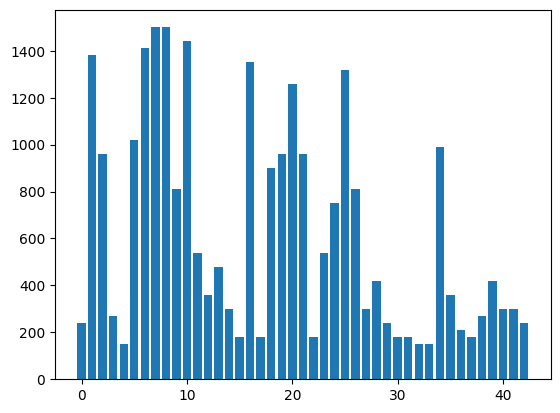

In [ ]:
# distribution by class-series in trainset
distr_by_class = [len(train[cls]) for cls in train.keys()]
plt.bar(range(0, len(train)), distr_by_class)

In [ ]:
# Create augmentations
#import albumentations as A
from torchvision import transforms as T
transform = T.Compose([
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # randomly adjusts the brightness, contrast, and saturation of the image within a certain range
    T.RandomAffine(degrees=15, translate=(0.1, 0.1)), # applies a random affine transformation to the image, including rotation, scaling, shearing, and translation. In this case, we are randomly rotating the image up to 15 degrees and translating it up to 10% of its width and height.
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.5), # Arandomly applies Gaussian blur to the image with a probability of 0.5
    #T.ToTensor(),
    #T.RandomErasing(p=0.5, scale=(0.02, 0.2)), # randomly erases a rectangular patch from the image with a probability of 0.5
    #T.ToPILImage()
])

def augment_set(set_, path):
  #target_size = max([len(set_[cls]) for cls in set_.keys()])
  target_size = 1000
  for cls in set_.keys():
    n = target_size - len(set_[cls])
    for i in trange(n):
      random_img = choice(set_[cls])
      img = Image.fromarray(imread(random_img))
      aug = transform(img)
      aug = np.array(aug)
      name = random_img.split('/')[-1].split('.')[0]
      # save augmented img
      imsave(f'{path}/{name}_aug_{i}.jpg', aug)
    for i,f in enumerate(set_[cls]):
      if i == 1000: break
      name = f.split('/')[-1]
      # save original img
      imsave(f'{path}/{name}', np.array(img))

In [ ]:
# Augmentation on train set
!rm GTSRB_AUG_TRAIN -rf
!mkdir GTSRB_AUG_TRAIN
print('Augment train set')
augment_set(train, 'GTSRB_AUG_TRAIN')

Augment train set


100%|██████████| 90/90 [00:00<00:00, 275.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1260/1260 [00:05<00:00, 229.18it/s]


In [ ]:
# load files with augmentations
train_set = glob.glob('GTSRB_AUG_TRAIN/*')
test_set = list(chain(*list(test.values())))
val_set = list(chain(*list(val.values())))

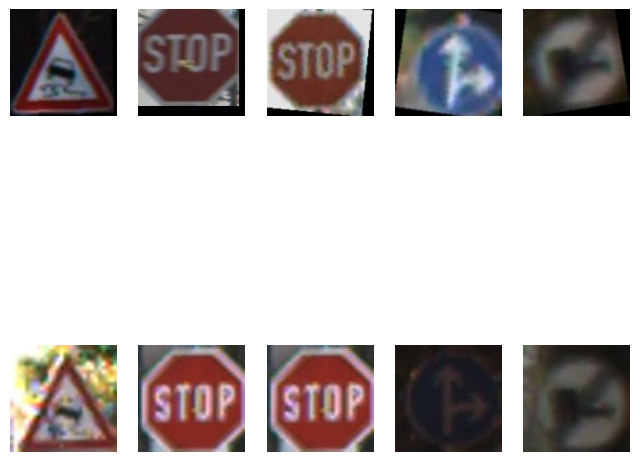

In [ ]:
# Show some augmented examples
augmented_files = glob.glob('GTSRB_AUG_TRAIN/*_aug*')[:5]
original_files = [f.split('_aug')[0]+'.jpg' for f in augmented_files]
aug_orig_files = augmented_files + original_files

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,8))
axes = axes.flatten()
for i in range(10):     
  axes[i].imshow(imread(aug_orig_files[i]))
  axes[i].axis('off')

<BarContainer object of 43 artists>

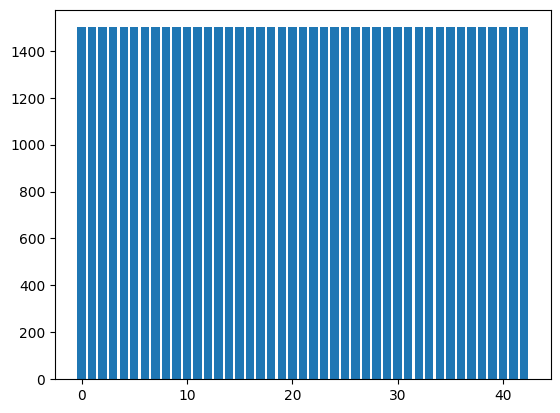

In [ ]:
# Show train distribution by class after augmentation
imgs_aug_by_class = {}
for f in train_set:
  cls_name = f.split('/')[-1].split('_')[0]
  if cls_name not in imgs_aug_by_class.keys():
    imgs_aug_by_class[cls_name] = [f]
  else:
    imgs_aug_by_class[cls_name].append(f)

distr_by_class = [len(imgs_aug_by_class[cls]) for cls in imgs_aug_by_class.keys()]
plt.bar(range(0, len(distr_by_class)), distr_by_class)

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
class MyDataset(Dataset):
  def __init__(self, dataset, is_test=False):
    self.dataset = dataset
    self.transform = transforms.Compose([
      #transforms.Scale((48, 48)),
      transforms.Resize((48, 48)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    self.is_test = is_test
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, index):
    # load img
    img_path = self.dataset[index]
    # load cls
    cls = torch.tensor(int(img_path.split('/')[-1].split('_')[0])).long()
    if self.is_test:
      img_path = img_path.split('/')[0] + '/' + img_path.split('/')[1].split('_')[1]
    img = Image.open(img_path)
    img = self.transform(img)
    
    return img, cls

In [ ]:
# Create train, val and test dataloaders
BS = 128
train_dataloader = DataLoader(MyDataset(train_set), batch_size=BS, collate_fn=None, shuffle=True)
val_dataloader = DataLoader(MyDataset(val_set, is_test=True), batch_size=BS, collate_fn=None, shuffle=True)
test_dataloader = DataLoader(MyDataset(test_set, is_test=True), batch_size=BS, collate_fn=None, shuffle=True)

In [ ]:
for imgs,clss in train_dataloader:
  print(imgs.shape)
  print(clss.shape)
  break

torch.Size([128, 3, 48, 48])
torch.Size([128])


In [ ]:
class MyModel(nn.Module):
  def __init__(self, classes=43):
    super(MyModel, self).__init__()
    self.convs = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, stride=2),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3, stride=2),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=3, stride=2),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, stride=3),
      nn.ReLU()
    )
    self.fc = nn.Sequential(
      nn.Linear(256*5*5, 1024),
      nn.ReLU(),
      nn.Linear(1024, 256),
      nn.ReLU(),
      nn.Linear(256, classes)
    )
    self.dropout = nn.Dropout(p=0.5)
  def forward(self, x):
    out = self.convs(x)
    out = self.dropout(out)
    # flatten
    flat = out.view(x.shape[0], -1)
    logits = self.fc(flat)
    return logits

In [ ]:
model = MyModel(43)
out = model(torch.rand(1, 3, 128, 128))
print(out.shape)

torch.Size([1, 43])


In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
resnet.fc.out_features = 43

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
#model = MyModel(43).cuda()
model = resnet.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_step(train_set):
  model.train()
  data = tqdm(train_set)
  losses, accuracies = [], []
  for img,cls in data:
    img = img.cuda()
    cls = cls.cuda()
    # forward
    out = model(img)
    # loss
    loss = criterion(out, cls)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    # show loss
    data.set_description('Loss: %.4f' % (loss.item()))

    # accuracy
    pred_cls = torch.argmax(out, dim=1)
    accuracy = (pred_cls == cls).float().mean()
    accuracy = accuracy.item()
    accuracies.append(accuracy)

  return sum(losses)/len(losses), sum(accuracies)/len(accuracies)

In [ ]:
def val_step(val_set):
  model.eval()
  data = tqdm(val_set)
  losses, accuracies = [], []
  for img,cls in data:
    img = img.cuda()
    cls = cls.cuda()
    # forward
    out = model(img)
    # loss
    loss = criterion(out, cls)
    losses.append(loss.item())

    # accuracy
    pred_cls = torch.argmax(out, dim=1)
    accuracy = (pred_cls == cls).float().mean()
    accuracy = accuracy.item()
    accuracies.append(accuracy)

  return sum(losses)/len(losses), sum(accuracies)/len(accuracies)

In [ ]:
EPOCHS = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for i in range(EPOCHS):
  train_loss, train_accuracy = train_step(train_dataloader)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  val_loss, val_accuracy = val_step(val_dataloader)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  print('\nEpoch %d' % i)
  print('Train loss: %.4f Validation loss %.4f' % (train_loss, val_loss))
  print('Train accuracy: %.4f Validation accuracy: %.4f' % (train_accuracy, val_accuracy))

100%|██████████| 50/50 [00:05<00:00,  8.78it/s]



Epoch 0
Train loss: 0.8680 Validation loss 3.1291
Train accuracy: 0.7861 Validation accuracy: 0.2984


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]



Epoch 1
Train loss: 0.1690 Validation loss 2.7630
Train accuracy: 0.9308 Validation accuracy: 0.4148


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]



Epoch 2
Train loss: 0.1146 Validation loss 2.7093
Train accuracy: 0.9452 Validation accuracy: 0.4766


100%|██████████| 50/50 [00:05<00:00,  8.97it/s]



Epoch 3
Train loss: 0.0998 Validation loss 2.7883
Train accuracy: 0.9488 Validation accuracy: 0.4787


100%|██████████| 50/50 [00:05<00:00,  9.19it/s]



Epoch 4
Train loss: 0.0941 Validation loss 2.7169
Train accuracy: 0.9503 Validation accuracy: 0.5009


100%|██████████| 50/50 [00:05<00:00,  9.44it/s]



Epoch 5
Train loss: 0.0965 Validation loss 2.8255
Train accuracy: 0.9503 Validation accuracy: 0.4852


100%|██████████| 50/50 [00:05<00:00,  8.81it/s]



Epoch 6
Train loss: 0.0919 Validation loss 2.9115
Train accuracy: 0.9499 Validation accuracy: 0.4845


100%|██████████| 50/50 [00:06<00:00,  8.28it/s]



Epoch 7
Train loss: 0.0868 Validation loss 2.7562
Train accuracy: 0.9508 Validation accuracy: 0.5137


 68%|██████▊   | 34/50 [00:04<00:02,  7.76it/s]

In [ ]:
plot(train_losses)
plot(val_losses)

In [ ]:
loss, acc = val_step(test_dataloader)
print()
print('LOSS:', loss)
print('ACC:', acc)